<details>
    <summary>Note to teachers (click me)</summary>

The data required for this notebook is stored in `/archive/casparl/packed_data_formats_data.tar.gz`. Unpack it in the `JHS_data` folder for the course when you want to use this notebook.
</details>

# Packed Data Formats

In this tutorial we will review two ways of saving our data that is then loaded in PyTorch


## Scenario: working with ImageNet data
Imagine we want to train a network which can classify images accurately. Here we will use the ImageNet dataset to train our network. ImageNet is a huge image database of 14 million images. Below are a few example images from this dataset:

<img src="src/imagenet.jpg" alt= "ImageNet" width="500" height="500">

So you download the dataset to your computer and unzip to see the images inside. However, extracting 14 million images is something your computer does not like for a couple of reasons:
- extracting individual files takes long
- all files are stored individually with their own metadata
- on Snellius, we mostly have a shared disk so whatever data-intense heavy tasks are running may impact other users

In this tutorial, you will learn how to work with large amounts of samples in a way that ensures reasonable performance for you _and_ other users on the cluster. We have selected 10000 random samples from the ImageNet dataset, and resampled them to the same resolution

## Python imports

Here, we import the python packages which we will be using throughout the notebook. We also se the path to the dataset that we will work on. You don't need to change anything here, just execute this cell.

In [1]:
import os
import glob
import time
import zipfile
import json
from pathlib import Path

import numpy as np
import PIL.Image
import torch
from torchvision import transforms

DATA_PATH = os.path.join(os.getenv("TEACHER_DIR", os.getcwd()), "JHS_data")
AUXILARY_DATA_ROOT = Path.home() / 'JHS_notebooks' / 'HPML-course-materials' / 'Day2' / 'notebooks' / 'data'

## Data inspection

Let's check the dimensions of these images, and visualize some of the images from this dataset. You may notice: we have done some preprocessing on these images by rescaling them to a uniform resolution.

In [2]:
# Let's define a convenience function to print the image dimension and display it
def print_dim_and_display(image_name):
    image_path = os.path.join(DATA_PATH, 'disk_transformed', image_name)
    img = PIL.Image.open(image_path)
    print(f"Image {image_name} has dimensions {img.size}")
    display(img)

Image img00000000.JPEG has dimensions (256, 256)


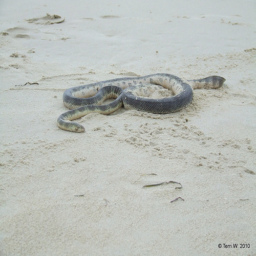

Image img00000001.JPEG has dimensions (256, 256)


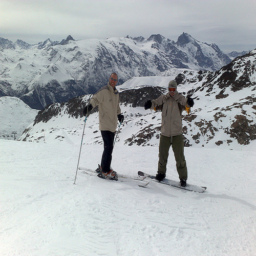

In [3]:
print_dim_and_display('img00000000.JPEG')
print_dim_and_display('img00000001.JPEG')

## Create a torch Dataset class for jpeg images

To load the JPEG images during training, we write our own Dataset class. A PyTorch dataset class _has_ to implement three methods: `__init__`, `__len__` and `__get_item__`. We won't go into detail here on _how_ to write a Custom Dataset class for your dataset (the official PyTorch documentation has a good description of that https://pytorch.org/tutorials/beginner/basics/data_tutorial.html ), but simply provide you with one.

Read it carefully and see if you can understand what is happening.

In [4]:
class JpegDataset(torch.utils.data.Dataset):
    """ImageNet10k Dataset for Jpeg images to pass to a PyTorch dataloader

    Args:
        path (str): location where the images are stored on disk
        transform (obj): torchvision.transforms object or None
    Returns:
        torch Dataset: to pass to a dataloader
    """
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

        # Store all names of the images in the zip in self.img_names
        self.img_names = self._get_img_names()
    
        # Read the labels from the zip file into self.labels
        label_fname = "validation_labels_10k.txt"
        self.labels = self._read_label_file(label_fname)

    def _get_img_names(self):
        return sorted(glob.glob(f"{self.path}/*.JPEG"))
        
    def _read_label_file(self, label_fname):
        with open(os.path.join(self.path, label_fname), "r") as file:
            return [int(l) for l in file.readlines()]

    @staticmethod
    def read_image(img_name):
        image = PIL.Image.open(img_name).convert("RGB")
        return image


    def __getitem__(self, index):
        img_name= self.img_names[index]
        image = self.read_image(img_name)
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label
    

    def __len__(self):
        return len(self.labels)

### Questions

- The labels are read from the file `validation_labels_10k.txt`. How often is this file read: once for the entire training, or once per epoch?

...

- The images are read by the `read_image` function, called from the `__getitem__` function. How often is each image read from disk: once for the entire training, or once per epoch?

...

- What happens if the `__getitem__` function contains heavy routines, e.g. if the transform function is very heavy?

...

- For a GPU based training: where is the `__getitem__` function executed, on GPU or CPU?

...

## Benchmark the Jpeg Dataset
In a real-life deep learning scenario, we have a dataloader which on every iteration returns images and labels of size `batch_size`. By running this for 1 epoch, we ensure that every images is seen at least once by the network. in this benchmarking example, only the timings of getting the images and pushing it to device is relevant. For now, we don't define any neural network training, we _only_ do dataloading.

In [5]:
def benchmark(dataset, epochs, batch_size, num_workers, persistent_workers, pin_memory, device, shuffle=True, warm_start=False):

    dataloader = torch.utils.data.DataLoader(
            dataset,
            num_workers=num_workers,
            batch_size=batch_size,
            shuffle=shuffle,
            persistent_workers=num_workers > 0 and persistent_workers,
            pin_memory=pin_memory,
        )
    
    if not warm_start:
            start = time.time()

    for epoch in range(epochs):
        if epoch == 1 and warm_start:
            start = time.time()
        timer_per_epoch = time.time()
        for i, (images, labels) in enumerate(dataloader):
            images, labels = map(
                    lambda tensor: tensor.to(device, non_blocking=pin_memory),
                    (images, labels),
                )

        print(f"Epoch {epoch} finished in {time.time() - timer_per_epoch}")
    total_time = time.time() - start
    return total_time 

## Initialize some dataloading parameters
Read careful and feel free to experiment with this. If you want to know more about the dataloader arguments, you can look them up in the official documentation at https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [6]:
dataloader_kwargs = {
    "epochs": 2,
    "num_workers": 1,
    "batch_size": 16,
    "device": "cuda",
    "persistent_workers": True,
    "warm_start": False,
    "pin_memory": True,
    "shuffle": True,
}

## Define a transform function

We include a transformation to imitate real-life applications

In [7]:
def transform(new_size, to_tensor=False):
    transform_list = []
    if to_tensor:
        transform_list.append(transforms.ToTensor())
    transform_list.append(transforms.Resize((new_size, new_size), antialias=True))
    transform_list.append(transforms.RandomHorizontalFlip())
    transform = transforms.Compose(transform_list)
    return transform

## Run the benchmark on the Jpeg data
Below, we
- define the transform
- initialize the JpegDataset object (passing it the defined transform)
- run the benchmark for two epochs, returning the timing for each one

In [8]:
img_path = f"{DATA_PATH}/disk_transformed"

transform_jpeg = transform(new_size=256, to_tensor=True)
jpeg_dataset = JpegDataset(img_path, transform=transform_jpeg)

jpeg_time = benchmark(jpeg_dataset, **dataloader_kwargs)

Epoch 0 finished in 46.23589253425598
Epoch 1 finished in 25.4307918548584


Results here might vary quite a bit. A typical result would be that Epoch 0 takes between 60 and 200 seconds, and Epoch 1 takes about 30 seconds.

### Questions

- Why do you think results vary? And why is the variation especially large for the first epoch? (hint: where are these files stored? Are you the only one using that filesystem?)

...

- Can you think of a reason why the second time is much faster?

...

# Using a local scratch disk
Sometimes, you might not have the possibility of using packed file formats, or the amount of work involved would be to substantial. E.g. if you want to use one of the TorchVision datasets, these generally read individual files. One thing you can do to limit your I/O footprint on the system, is to use a node with a local scratch disk.

Here, we copy the individual jpeg data to the local scratch disk of the node on which you are working (i.e. the node that is running this Jupyter Notebook Server). 

In [9]:
!cp -r $TEACHER_DIR/JHS_data/disk_transformed $TMPDIR

Then, we run the benchmark again, using the dataloader that loads individual jpegs

In [10]:
img_path = os.path.join(os.getenv("TMPDIR"), "disk_transformed")

transform_jpeg = transform(new_size=256, to_tensor=True)
jpeg_dataset = JpegDataset(img_path, transform=transform_jpeg)

jpeg_time = benchmark(jpeg_dataset, **dataloader_kwargs)

Epoch 0 finished in 22.662429809570312
Epoch 1 finished in 21.55581259727478


The result should be that it finishes in around 30 seconds. Probably, you've also seen little difference between the first and second epoch. So, there is little effect of caching. This makes sense, since we read from a _local_ NVME drive, which makes it very fast. Also, the only people with whom you are competing for resources are other users on the same node.

There are some limitations:
- Not all systems have local scratch disks in the nodes. Snellius has _some_ nodes with local scratch disks (can be requested with `--constraint=scratch-node`). Requesting these specifically will mean longer queue times on average.
- Local scratch disks typically have much less space than network filesystems (6 TB in Snellius, quota determined proportionally to the node allocation fraction. E.g. allocating 1 GPU limits you to 1.5 TB of space on `scratch-node`).

## Packed data formats
As we have already discussed, storing and loading a lot of individual files can lead to poor performance for both the filesystem as well as your network training. Packed data formats are data formats that store multiple samples in the same file. The simplest, and possibly most well known example, is a zip or tar file. However, there are many packed dataformats, such as HDF5, lmdb, petastorm and TFRecords.

Reading samples from a packed file format is much friendlier on the filesystem, because there is _only_ one file for which the filesystem needs to lookup the metadata. An additional advantage is that it is much easier to manage one (or a few) files, than millions of individual files. Simply listing a folder with 10k images with `ls` takes a few seconds - imagine if you have millions of samples!

Instead of a Jpeg dataset class, let's make a dataclass for zip files.

In [11]:
class ZIPDataset(torch.utils.data.Dataset):
    """ImageNet10k Dataset for packed ZIP to pass to a PyTorch dataloader

    Args:
        path (str): location where the images are stored on disk
        transform (obj): torchvision.transforms object or None
        load_encoded (bool): whether the images within the .zip file are encoded or saved as bytes directly
    Returns:
        torch Dataset: to pass to a dataloader
    """
    def __init__(self, path, transform=None, load_encoded=False):
        self.path = path
        self.transform = transform
        self.load_encoded = load_encoded

        self.zip_file = zipfile.ZipFile(path)
        self.members = sorted(self.zip_file.namelist())

        # Store all names of the images in the zip in self.img_names
        self.img_names = self._get_img_names()

        # Read the labels from the zip file into self.labels
        label_fname = "dataset.json"
        self.labels = self._get_labels(label_fname)

    def _get_img_names(self):
        PIL.Image.init()
        return [m for m in self.members if m.lower().endswith(tuple(PIL.Image.EXTENSION.keys()))]

    def _get_labels(self, label_fname):
        label_file = self.zip_file.open(label_fname, "r")
        return json.load(label_file)["labels"]


    def _get_image(self, img_fname, shape=(3, 256, 256)):
        img_f = self.zip_file.open(img_fname, "r")
        if self.load_encoded:
            image = PIL.Image.open(img_f).convert("RGB")
        else:
            buffer = np.frombuffer(img_f.read(), dtype=np.uint8).reshape(shape)
            image = torch.tensor(buffer) # make writeable copy
        return image


    def __getitem__(self, index):
        img_fname = self.img_names[index]
        image = self._get_image(img_fname)
        label = self.labels[img_fname]
        
        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.img_names)



## Benchmark the zip file

In [12]:
zip_path = f"{DATA_PATH}/zip_encoded/part0.zip"
transform_zip = transform(new_size=256, to_tensor=True)
zip_dataset = ZIPDataset(zip_path, transform=transform_zip, load_encoded=True)
zip_time = benchmark(zip_dataset, **dataloader_kwargs)

Epoch 0 finished in 45.87126898765564
Epoch 1 finished in 53.244529724121094


Although results on the zip-file can still vary depending on the load other users put on the filesystem, it is likely more predictable. A typical result would be that Epoch 0 takes 60 seconds, and Epoch 1 takes about 50 seconds.

## Comparing the results to the individual JPEG approach

As you can see, the JPEG approach is slower, _but only for the first epoch_. So: you might be a bit confused now. Didn't we say that packed file formats are a good idea?

Well, that's because _they are_. The only reason the dataset with individual JPEGs was faster in this case is because our filesystem managed to cache them. The problem here is twofold:
- First epoch, you are still _heavily_ hitting the filesystem, which may slow it down substantially for other users
- Whether the dataset will be cached is unpredictable, as it depends on several factors (size of the dataset, but also how much other users are using the cache)

With both points, the issue is that if _one_ user does it, it is usually not a problem. But an HPC system can have hundreds of users, and if they _all_ do this, performance will be greatly affected. 

You might wonder: why did I never worry about this when training networks on my own laptop? The reason is twofold: 
1) the disk in your laptop is used _only_ by you. Thus, you are not competing for I/O performance.
2) the disk in your laptop is _local_. Serving files over a network, especially if these are small files, result in higher latency and thus fewer file reads per second.

One final note: it is good to realize that as long as your compute takes longer than preloading the next batch from disk _you are never waiting for IO_. Suppose that in the above example, the compute time for one epoch would be 90 seconds. That would mean that with the ZIP-dataloader, you would _never_ wait for I/O, whereas with the JPEG-dataloader, you would be waiting for I/O whenever the dataset can _not_ be read from cache.

# But can we do better? Multiworker support!

Up until this point, we've only used a single thread to do the dataloading. However, the dataloaders are _also_ in charge of the transformations. I.e. the transformations as defined by the `transform` function are executed by the dataloading threads. If these take a lot of time, it can be useful to have _more_ threads working on this. Moreover: by reading multiple samples simultaneously, you are often able to get a higher aggregate I/O from the filesystem.

Let's change the dataloader settings to increase the number of processes to say 8.

In [13]:
# Change the number of workers to 8
dataloader_kwargs["num_workers"] = 8
# Re-run the JPEG dataset benchmark and 
jpeg_time_multi = benchmark(jpeg_dataset, **dataloader_kwargs)
# Re-run the ZIP dataset benchmark and call the benchmark time
zip_time_multi = benchmark(zip_dataset, **dataloader_kwargs)

/projects/jhssrf014/JHS_installations/Python/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0 finished in 29.933321237564087
Epoch 1 finished in 18.091987133026123


BadZipFile: Caught BadZipFile in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/projects/jhssrf014/JHS_installations/Python/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/projects/jhssrf014/JHS_installations/Python/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/projects/jhssrf014/JHS_installations/Python/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/scratch-local/scur1075.7739589/ipykernel_1480839/2036557353.py", line 47, in __getitem__
    image = self._get_image(img_fname)
  File "/scratch-local/scur1075.7739589/ipykernel_1480839/2036557353.py", line 36, in _get_image
    img_f = self.zip_file.open(img_fname, "r")
  File "/sw/arch/RHEL8/EB_production/2022/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/zipfile.py", line 1533, in open
    raise BadZipFile("Bad magic number for file header")
zipfile.BadZipFile: Bad magic number for file header


Ouch... We got a weird BadZipFile error from ZIP with two file names having different headers or a bad magic number for file header... What could this be?


What is happening is that the images are all zipped in a single ZIP file. While loading the data, we set the number of processes that read the data to 8 (where did we set it?). All these processes are trying to open and read using the same file handle. This causes the issue.

## ReWriting the ZIP Dataset class for multi-worker support

In our previous `__init__`, the `self.zip_file = zipfile.ZipFile(path)` line created a single file handle, which was used by all workers. This does not work if we have multiple processes: one thing a file handle keeps track of is where in the file it is reading. If multiple processes are reading at the same time, this causes conflict.

Thus, we need to adapt the ZIP dataset class so that each worker gets its own file handle to the same zipfile. That way, each worker can read from its own position in the file, without affecting others.

This is done in the following four steps:
 - Create the workers
 - Get the information about the workers (the worker-id)
 - Give each worker a separate handle
 - Read the images and labels using this handle
 
 Tips:
 - Multiple workers are only created _after_ the `__init__`, so the creation of the file handle _per worker_ has to be triggered by the `__getitem__`.
 - Fill in the new `_get_file_handle` function
 - Revise the code from the previous dataset for loading the labels and images
 
  


In [ ]:
class MultiWorkerZIPDataset(torch.utils.data.Dataset):
    """ImageNet10k Dataset for packed ZIP to pass to a PyTorch dataloader

    Args:
        path (str): location where the images are stored on disk
        transform (obj): torchvision.transforms object or None
        load_encoded (bool): whether the images within the .zip file are encoded or saved as bytes directly
    Returns:
        torch Dataset: to pass to a dataloader
    """
    def __init__(self, path, transform=None, load_encoded=False):
        self.path = path
        self.transform = transform
        self.load_encoded = load_encoded

        # We get a temporary file handle, just to be able to read _what_ files are in the zip
        zip_handle = zipfile.ZipFile(path)
        self.members = sorted(zip_handle.namelist())
        
        # We also create a dict of zip handles, which will hold a zip handle for each worker later on
        self.zip_handle = {}

        # Store all names of the images in the zip in self.img_names
        self.img_names = self._get_img_names()

        # Read the labels from the zip file into self.labels
        label_fname = "dataset.json"
        self.labels = self._get_labels(zip_handle, label_fname)

    def _get_img_names(self):
        PIL.Image.init()
        return [m for m in self.members if m.lower().endswith(tuple(PIL.Image.EXTENSION.keys()))]

    def _get_labels(self, zip_handle, label_fname):
        label_file = zip_handle.open(label_fname, "r")
        return json.load(label_file)["labels"]

    def _get_file_handle(self, fname):
        # TODO: 
        # This function must return the file handle for the current worker, 
        # or create one if it is not already created
        worker = torch.utils.data.get_worker_info()
        worker = worker.id if worker else None

        if worker not in self.zip_handle:
            self.zip_handle[worker] = zipfile.ZipFile(self.path)

        return self.zip_handle[worker].open(fname, "r")

    def _get_image(self, img_fname, shape=(3, 256, 256)):
        img_f = self._get_file_handle(img_fname)
        if self.load_encoded:
            image = PIL.Image.open(img_f).convert("RGB")
        else:
            buffer = np.frombuffer(img_f.read(), dtype=np.uint8).reshape(shape)
            image = torch.tensor(buffer) # make writeable copy
        return image


    def __getitem__(self, index):
        img_fname = self.img_names[index]
        image = self._get_image(img_fname)
        label = self.labels[img_fname]
        
        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.img_names)

    def __del__(self):
        """Clean all file handles of the workers on exit"""
        if hasattr(self, "zip_handle"):
            for o in self.zip_handle.values():
                o.close()

    def __getstate__(self):
        """Serialize without the ZipFile references, for multiprocessing compatibility"""
        state = dict(self.__dict__)
        state["zip_handle"] = {}
        return state


In [ ]:
zip_dataset_multi = MultiWorkerZIPDataset(zip_path, transform=transform_zip, load_encoded=True)
zip_time_multi = benchmark(zip_dataset_multi, **dataloader_kwargs)

In [ ]:
speed_up = zip_time / zip_time_multi
print(f'Speed up of zip dataset using {dataloader_kwargs["num_workers"]} workers: {round(speed_up, 3)}x faster')

Note: if you are in a course environment with GPUs, you may see limited speedup here, as there are only 2 CPU cores available per notebook. So, having more than two workers, they start competing for the same CPU resources. In a real batch job, you typically have way more CPU cores per GPU available and you would likely see a larger speedup. Returns typically diminish for large amount of workers.

# Exercise 1

We have prepared a tiny dataset of just 10 JPEG images in the `Day2/notebooks/data` directory. The labels are stored in a `.json` file, which has the same structure as the one in the ZipDataset we've used above.

The exercise is to run the benchmark first on the individual JPEG images, then on the zip file. Note that the timings for such a tiny dataset are not reliable at all, and we'll ignore them here: this exercise is just to practice and see what you need to do to convert things from a JPEG Dataset to a Zip Dataset.

First, you'll need to adapt the label reading for the jpeg dataset. Our initial JpegDataset assumes the labels are in a `txt` file, and that the first entry just corresponds to the first JPEG image. That is not the case here: here, we have the labels in a `json` file, and the labels are stored as key-value pairs, with the filenames as key.

Let's see what is in the `.json` file, so that you know how to extract the labels from it:

In [ ]:
HOMEDIR = os.getenv('HOME')
json_file = os.path.join(HOMEDIR, 'JHS_notebooks', 'HPML-course-materials', 'Day2', 'notebooks', 'data', 'dataset.json')
with open(json_file, "r") as file:
    print(json.load(file))

## Exercise 1.a

We start of with the regular JpegDataset, and have indicated where you will need to make the changes. You can get inspiration from how we read the labels from the `json` file in the ZipDataset above. 

In [ ]:
class JpegDataset(torch.utils.data.Dataset):
    """ImageNet10k Dataset for Jpeg images to pass to a PyTorch dataloader

    Args:
        path (str): location where the images are stored on disk
        transform (obj): torchvision.transforms object or None
    Returns:
        torch Dataset: to pass to a dataloader
    """
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

        # Store all names of the images in the zip in self.img_names
        self.img_names = self._get_img_names()

        # Read the labels from the zip file into self.labels
## ====================================================
## CHANGE IS NEEDED HERE:
        label_fname = "validation_labels_10k.txt"
## ====================================================
        self.labels = self._read_label_file(label_fname)

    def _get_img_names(self):
        return sorted(glob.glob(f"{self.path}/*.JPEG"))
        
    def _read_label_file(self, label_fname):
        with open(os.path.join(self.path, label_fname), "r") as file:
## ====================================================
## CHANGES IS NEEDED HERE:
            return [int(l) for l in file.readlines()]
## ====================================================

    @staticmethod
    def read_image(img_name):
        image = PIL.Image.open(img_name).convert("RGB")
        return image


    def __getitem__(self, index):
        img_name= self.img_names[index]
        image = self.read_image(img_name)
## ====================================================
## CHANGES IS NEEDED HERE:
## Hint: img_name is the full path to the image, while the keys in the json file are the filenames
## You can get the filename from the full path using os.path.basename()
        label = self.labels[index]
## ====================================================

        if self.transform:
            image = self.transform(image)

        return image, label
    

    def __len__(self):
        return len(self.labels)

## Exercise 1.b

Now, create the JpegDataset instance and run the benchmark function - similar to how we did it above. We've already defined the correct path for you.

In [ ]:
HOMEDIR = os.getenv('HOME')
img_path = AUXILARY_DATA_ROOT / 'data')

jpeg_dataset = ...

jpeg_time = ...

## Exercise 1.c

Next, you'll have to zip the imaging data. The easiest way to do this is on the command line. 
- Open a Terminal from the main Notebook Server (where you see all the files in your home directory)
- Use `cd` to change directory to the `JHS_notebooks/Day2/notebooks/data` subdirectory in your homedir
- Run `zip -0 myzip.zip img0000000* dataset.json`

N.B. with `-0` you store files in a zip without compressing them. This uses more disk space, but less CPU when extracting the data. Since images are hardly compressible anyway, it makes sense to store them without compression. For highly compressible data (like text) it _might_ be worth compressing in order to save some disk space - as long as you have enough (CPU) workers to do the decompression work.

## Exercise 1.d

Create a `MultiWorkerZIPDataset`, and run the `benchmark()` function on it.


In [ ]:
HOMEDIR = os.getenv('HOME')
zip_path = os.path.join(HOMEDIR, 'JHS_notebooks', 'MLonHPC_2day_Okt2023', 'Day2', 'notebooks', 'data', 'myzip.zip')

zip_dataset_multi = ...
zip_time_multi = ...

## Bonus Exercise
- Try to change the number of workers to any number between 1 and 16, see what happens with the speed-up!

# Recap

- Dataloading individual JPEGs is slower, unless they are cached
- Dataloading from a local scratch disk is faster, and has less impact on other users. On local scratch disk, the use of individual JPEGs is acceptable, though it still has limitations (dataset size, availability of nodes with a local scratch disk). It is an option for example when you cannot control the dataset format, e.g. when using torchvision datasets.
- Dataloading from a packed file format provides more predictable performance, regardless of caching behaviour
- Dataloading from a packed file format puts less load on the filesystem. This is important in HPC clusters, where a lot of users are using the same filesystem.


### Final remarks


Other tips:
- Any transformation on your dataset which is deterministic (for example resize) can be done once in advance as preprocessing and will probably save you time during the actual training.
- While working with zip is probably the easiest and most familiar packed data format, there are other packed data formats which may be more suitable / more performant for you data (e.g. LMDB/HDF5/Petastorm
- More info here: https://servicedesk.surf.nl/wiki/display/WIKI/Best+Practice+for+Data+Formats+in+Deep+Learning and here: \newline https://github.com/sara-nl/Packed-Data-Formats


Finally, it's good to keep in mind that reading files is a task which we can partially do in a overlapping way with GPU computations. In this hands-out, we did not consider a neural network so the GPU was idle at all times. In real-life scenarios, we can push the data to the GPU, let the GPU do its calculations and at the same time load some more data for the next batch.  